## Unsupervised Pretraining Using Stacked Autoencoders

As we discussed in Chapter 11, if you are tackling a complex supervised task but you do not have a lot of labeled training data, one solution is to find a neural network that performs a similar task and reuse its lower layers. This makes it possible to train a high-performance model using little training data because your neural network won’t have to learn all the low-level features it will just reuse the feature detectors learned by the existing network.

Similarly, if you have a large dataset but most of it is unlabeled, you can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for your actual task and train it using the labeled data. For example, Figure 17-6 shows how to use a stacked autoencoder to perform unsupervised pretraining for a classification neural network. When training the classifier, if you really don’t have much labeled training data, you may want to freeze the pretrained layers.

### Example

####  Data Preprocessing

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

In [0]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [0]:
X_train.shape

(60000, 28, 28)

In [0]:
X_train = X_train/255.0
X_test = X_test/255.0

In [0]:
X_train_labeled = X_train[:200]
y_train_labeled = y_train[:200]

In [0]:
#X_train_nolabeled = X_train[500:]

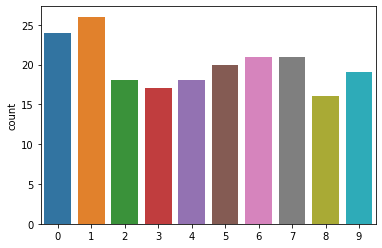

In [0]:
sns.countplot(y_train_labeled)

#### Model usgin CNN with only labeled data

In [0]:
keras.backend.clear_session()

In [0]:
model = keras.models.Sequential([
                                 keras.layers.Reshape((28,28,1), input_shape=(28,28)),

                                 keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPool2D(pool_size=2),
                                 keras.layers.Dropout(0.2),

                                 keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPool2D(pool_size=2),
                                 keras.layers.Dropout(0.3),

                                 keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPool2D(pool_size=2),
                                 keras.layers.Dropout(0.4),

                                 keras.layers.Flatten(),
                                 keras.layers.Dense(32, activation='selu'),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(10, activation='softmax')


])

In [0]:
#model.summary()

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['acc'])

In [0]:
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [0]:
history = model.fit(X_train_labeled, y_train_labeled, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping])

Train on 200 samples, validate on 10000 samples
Epoch 1/200
200/200 [==============================] - 4s 18ms/sample - loss: 5.8273 - acc: 0.1200 - val_loss: 2.2947 - val_acc: 0.0881
Epoch 2/200
200/200 [==============================] - 1s 4ms/sample - loss: 3.3481 - acc: 0.2450 - val_loss: 2.2888 - val_acc: 0.1207
Epoch 3/200
200/200 [==============================] - 1s 4ms/sample - loss: 3.0976 - acc: 0.2900 - val_loss: 2.3015 - val_acc: 0.1170
Epoch 4/200
200/200 [==============================] - 1s 4ms/sample - loss: 2.4554 - acc: 0.4300 - val_loss: 2.3198 - val_acc: 0.0973
Epoch 5/200
200/200 [==============================] - 1s 4ms/sample - loss: 2.1527 - acc: 0.4000 - val_loss: 2.3632 - val_acc: 0.1000
Epoch 6/200
200/200 [==============================] - 1s 4ms/sample - loss: 1.9882 - acc: 0.5150 - val_loss: 2.4032 - val_acc: 0.1000
Epoch 7/200
200/200 [==============================] - 1s 4ms/sample - loss: 1.9907 - acc: 0.4350 - val_loss: 2.4859 - val_acc: 0.1000
Epoch 

#### Modeil using autoencoderes to pretrain de weights

In [0]:
keras.backend.clear_session()

In [0]:
def autoencoder():
  img_input = keras.layers.Input(shape=(28,28,))

  img = keras.layers.Reshape((28,28,1), input_shape=(28,28))(img_input)
  conv_1 = keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(img)
  bn_1 = keras.layers.BatchNormalization()(conv_1)
  pool_1 = keras.layers.MaxPool2D(pool_size=2)(bn_1)
  drop_1 = keras.layers.Dropout(0.2)(pool_1)

  conv_2 = keras.layers.Conv2D(32, kernel_size=32, padding='same', activation='relu',kernel_initializer='he_normal')(drop_1)
  bn_2 = keras.layers.BatchNormalization()(conv_2)
  pool_2 = keras.layers.MaxPool2D(pool_size=2)(bn_2)
  drop_2 = keras.layers.Dropout(0.3)(pool_2)

  conv_3 = keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu',kernel_initializer='he_normal')(drop_2)
  bn_3 = keras.layers.BatchNormalization()(conv_3)
  conv_3 = keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu',kernel_initializer='he_normal')(bn_3)
  bn_3 = keras.layers.BatchNormalization()(conv_3)
  pool_3 = keras.layers.MaxPool2D(pool_size=2)(bn_3)
  drop_3 = keras.layers.Dropout(0.4)(pool_3)



  deconv_1 = keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', activation='relu',kernel_initializer='he_normal')(drop_3)
  bn_1 = keras.layers.BatchNormalization()(deconv_1)

  deconv_2 = keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu',kernel_initializer='he_normal')(bn_1)
  bn_2 = keras.layers.BatchNormalization()(deconv_2)

  output = keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(bn_2)

  output = keras.layers.Reshape([28, 28])(output)
 
 



  return keras.Model(img_input, output)


In [0]:
model = autoencoder()

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        524320

In [0]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [0]:
model.compile(loss='mse', optimizer=keras.optimizers.Nadam(learning_rate=0.01))

In [0]:
model.fit(X_train, X_train, epochs=40, batch_size=128 ,validation_data=(X_test, X_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 11s 180us/sample - loss: 0.0249 - val_loss: 0.0142
Epoch 2/40
60000/60000 [==============================] - 8s 139us/sample - loss: 0.0149 - val_loss: 0.0114
Epoch 3/40
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0132 - val_loss: 0.0109
Epoch 4/40
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0122 - val_loss: 0.0091
Epoch 5/40
60000/60000 [==============================] - 8s 139us/sample - loss: 0.0116 - val_loss: 0.0086
Epoch 6/40
60000/60000 [==============================] - 8s 139us/sample - loss: 0.0112 - val_loss: 0.0077
Epoch 7/40
60000/60000 [==============================] - 8s 139us/sample - loss: 0.0108 - val_loss: 0.0075
Epoch 8/40
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0106 - val_loss: 0.0069
Epoch 9/40
60000/60000 [==============================] - 8s 137us/sample - loss: 0.0

In [0]:
image_predicted = model.predict(X_test)

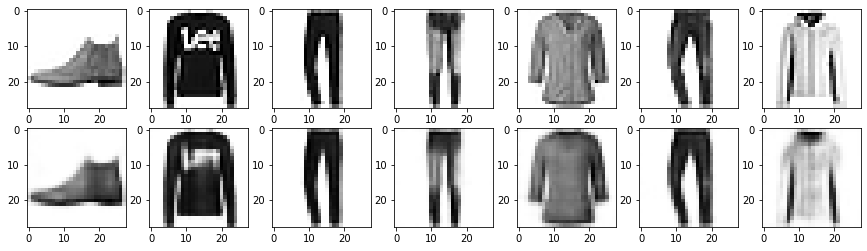

In [0]:
fig , ax = plt.subplots(2,7, figsize=(15,4))

for i in range(7):
  ax[0,i].imshow(X_test[i], cmap='binary')
  ax[1,i].imshow(image_predicted[i], cmap='binary')

In [0]:
model.save('autoencoder.h5')

In [0]:
keras.backend.clear_session()

#### Using transfer learning

In [0]:
keras.backend.clear_session()

In [0]:
laod_model = keras.models.load_model('autoencoder.h5')

In [0]:
laod_model.layers[:16]

In [0]:
model = keras.models.Sequential(laod_model.layers[:16])

In [0]:
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(128, activation='selu', kernel_initializer='lecun_normal'))
#model.add(keras.layers.Dropout(0.3, name='drop_1'))
#model.add(keras.layers.Dense(64, activation='selu', kernel_initializer='lecun_normal'))
#model.add(keras.layers.Dropout(0.5, name='drop_2'))
model.add(keras.layers.Dense(32, activation='selu', kernel_initializer='lecun_normal'))
model.add(keras.layers.Dropout(0.5, name='drop_3'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [0]:
for layers in laod_model.layers:
  layers.trainable = False

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Nadam(learning_rate=0.0005), metrics=['acc'])

In [0]:
#early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [0]:
history = model.fit(X_train_labeled, y_train_labeled,batch_size=32  ,epochs=20, validation_data=(X_test, y_test))

Train on 200 samples, validate on 10000 samples
Epoch 1/20
200/200 [==============================] - 2s 8ms/sample - loss: 3.1840 - acc: 0.1250 - val_loss: 2.4119 - val_acc: 0.0933
Epoch 2/20
200/200 [==============================] - 1s 4ms/sample - loss: 2.9533 - acc: 0.0900 - val_loss: 2.0179 - val_acc: 0.2445
Epoch 3/20
200/200 [==============================] - 1s 4ms/sample - loss: 2.4017 - acc: 0.2250 - val_loss: 1.7216 - val_acc: 0.4068
Epoch 4/20
200/200 [==============================] - 1s 4ms/sample - loss: 2.1600 - acc: 0.2950 - val_loss: 1.5014 - val_acc: 0.5183
Epoch 5/20
200/200 [==============================] - 1s 4ms/sample - loss: 1.8512 - acc: 0.3800 - val_loss: 1.3635 - val_acc: 0.5656
Epoch 6/20
200/200 [==============================] - 1s 4ms/sample - loss: 1.6448 - acc: 0.4100 - val_loss: 1.2653 - val_acc: 0.5941
Epoch 7/20
200/200 [==============================] - 1s 4ms/sample - loss: 1.3948 - acc: 0.4900 - val_loss: 1.1944 - val_acc: 0.6155
Epoch 8/20
200

In [0]:
for layers in laod_model.layers:
  layers.trainable = True

In [0]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='nadam', metrics=['acc'])

In [0]:
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [0]:
history = model.fit(X_train_labeled, y_train_labeled, epochs=100, batch_size=32  ,validation_data=(X_test, y_test), callbacks=[early_stopping])

Train on 200 samples, validate on 10000 samples
Epoch 1/100
200/200 [==============================] - 2s 12ms/sample - loss: 0.7833 - acc: 0.7550 - val_loss: 0.9062 - val_acc: 0.6956
Epoch 2/100
200/200 [==============================] - 1s 4ms/sample - loss: 0.7647 - acc: 0.7650 - val_loss: 0.8841 - val_acc: 0.7036
Epoch 3/100
200/200 [==============================] - 1s 5ms/sample - loss: 0.7535 - acc: 0.7850 - val_loss: 0.8538 - val_acc: 0.7122
Epoch 4/100
200/200 [==============================] - 1s 4ms/sample - loss: 0.7344 - acc: 0.7850 - val_loss: 0.8580 - val_acc: 0.7115
Epoch 5/100
200/200 [==============================] - 1s 4ms/sample - loss: 0.6212 - acc: 0.8100 - val_loss: 0.8317 - val_acc: 0.7285
Epoch 6/100
200/200 [==============================] - 1s 4ms/sample - loss: 0.6463 - acc: 0.7750 - val_loss: 0.8535 - val_acc: 0.7187
Epoch 7/100
200/200 [==============================] - 1s 4ms/sample - loss: 0.6004 - acc: 0.8000 - val_loss: 0.8310 - val_acc: 0.7328
Epoch 

## Fully Convolutional Networks

###FCN

The idea of FCNs was first introduced in a 2015 paper by Jonathan Long et al., for semantic segmentation (the task of classifying every pixel in an image according to the class of the object it belongs to). suppose a dense layer with 200 neurons sits on top of a convolutional layer that outputs 100 feature maps, each of size 7 × 7 (this is the feature map size, not the kernel size). Each neuron will compute a weighted sum of all 100 × 7 × 7 activations from the convolutional layer (plus a bias term).

In [0]:
 %tensorflow_version 2.x 

TensorFlow 2.x selected.


In [0]:
from tensorflow import keras

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [0]:
model = keras.models.Sequential([
                                 keras.layers.Conv2D(100,kernel_size=3, padding='same' ,input_shape=[7,7,1]),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(200)

])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 7, 100)         1000      
_________________________________________________________________
flatten (Flatten)            (None, 4900)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               980200    
Total params: 981,200
Trainable params: 981,200
Non-trainable params: 0
_________________________________________________________________


Now let’s see what happens if we replace the dense layer with a convolutional layer using 200 filters, each of size 7 × 7, and with "valid" padding.

In [0]:
model = keras.models.Sequential([
                                 keras.layers.Conv2D(100,kernel_size=3, padding='same' ,input_shape=[7,7,1]),
                                 keras.layers.Conv2D(200, kernel_size=7, padding='valid')
])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 7, 7, 100)         1000      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 200)         980200    
Total params: 981,200
Trainable params: 981,200
Non-trainable params: 0
_________________________________________________________________


TPI: To convert a dense layer to a convolutional layer, the number of filters in the convolutional layer must be equal to the number of units in the dense layer, the filter size must be equal to the size of the input feature maps, and you must use "valid" padding. The stride may be set to 1 or more, as we will see shortly.

Why is this important? Well, while a dense layer expects a specific input size (since it has one weight per input feature), a convolutional layer will happily process images of any size (however, it does expect its inputs to have a specific number of channels, since each kernel contains a different set of weights for each input channel). Since an FCN contains only convolutional layers (and pooling layers, which have the same property), it can be trained and executed on images of any size!. 
For example, suppose we’d already trained a CNN for flower classification and localization. It was trained on 224 × 224 images, and it outputs 10 numbers: outputs 0 to 4 are sent through the softmax activation function, and this gives the class probabilities (one per class); output 5 is sent through the logistic activation function, and this gives the objectness score; outputs 6 to 9 do not use any activation function, and they represent the bounding box’s center coordinates, as well as its height and width. We can now convert its dense layers to convolutional layers. In fact, we don’t even need to retrain it; we can just copy the weights from the dense layers to the convolutional layers!

Now suppose the last convolutional layer before the output layer (also called the bottleneck layer) outputs 7 × 7 feature maps when the network is fed a 224 × 224 image (see the left side of Figure 14- 25). If we feed the FCN a 448 × 448 image (see the right side of Figure 14-25), the bottleneck layer will now output 14 × 14 feature maps. Since the dense output layer was replaced by a
convolutional layer using 10 filters of size 7 × 7, with "valid" padding and stride 1, the output will be composed of 10 features maps, each of size 8 × 8 (since 14 – 7 + 1 = 8). In other words, the FCN will process the whole image only once, and it will output an 8 × 8 grid where each cell contains 10
numbers (5 class probabilities, 1 objectness score, and 4 bounding box coordinates). It’s exactly like taking the original CNN and sliding it across the image using 8 steps per row and 8 steps per column. To visualize this, imagine chopping the original image into a 14 × 14 grid, then sliding a 7 × 7
window across this grid; there will be 8 × 8 = 64 possible locations for the window, hence 8 × 8 predictions. However, the FCN approach is much more efficient, since the network only looks at the image once. In fact, You Only Look Once (YOLO) is the name of a very popular object detection architecture, which we’ll look at next.

<p><img alt="Colaboratory logo" height="350px" src="https://i.imgur.com/rrCdQLP.png" align="center" hspace="10px" vspace="0px"></p> 

### Example 

In [0]:
 %tensorflow_version 2.x 

TensorFlow 2.x selected.


In [0]:
from tensorflow import keras

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [0]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data( )

In [0]:
X_train = X_train/255.0
X_test = X_test/255.

In [0]:
keras.backend.clear_session()

In [0]:
model = keras.models.Sequential([
                                 keras.layers.Reshape((28,28,1), input_shape=(28,28)),
                                 keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='elu'),
                                 keras.layers.MaxPool2D(pool_size=2),
                                 keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='elu'),
                                 keras.layers.MaxPool2D(pool_size=2),
                                 keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='elu'),
                                 keras.layers.MaxPool2D(pool_size=2),


                                 keras.layers.Conv2D(10, kernel_size=3, padding='valid', activation='softmax')
])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])

In [0]:
y_train_changed = []
for j in range(len(y_train)):
  n_classes = np.zeros((1 ,1 ,10))
  for i in range(10):
    n_classes[:,:,i] = (y_train[j]==i)*1.0
  #print(n_classes)

  y_train_changed.append(n_classes)
y_train_changed = np.array(y_train_changed).astype(int)

In [0]:
y_train_changed.shape

(60000, 1, 1, 10)

In [0]:
y_train_changed.dtype

dtype('int64')

In [0]:
model.fit(X_train,y_train_changed, epochs=5, batch_size=32)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 12s 195us/sample - loss: 0.1511 - acc: 0.9542
Epoch 2/5
60000/60000 [==============================] - 8s 140us/sample - loss: 0.0499 - acc: 0.9841
Epoch 3/5
60000/60000 [==============================] - 8s 141us/sample - loss: 0.0343 - acc: 0.9891
Epoch 4/5
60000/60000 [==============================] - 8s 142us/sample - loss: 0.0280 - acc: 0.9914
Epoch 5/5
60000/60000 [==============================] - 8s 140us/sample - loss: 0.0226 - acc: 0.9927


In [0]:
model.predict_classes(X_test[:1])

array([[[7]]])

## [Link](https://drive.google.com/open?id=1bLNM2dxfEUGl5zWhvwpPYzhoocXnvkb_) Del dataset para segmentacion . las imagenes preprocesadas estan los los .npy

## Semantic Segmentation

In semantic segmentation, each pixel is classified according to the class of the object it belongs to, as show in the figure (e.g., road, car, pedestrian, building, etc.). Note that different objects of the same class are not distinguished. For example, all the bicycles on the right side of the segmented image end up as one big lump of pixels. The main difficulty in this task is that when images go through a regular CNN, they gradually lose their spatial resolution (due to the layers with strides greater than 1); so, a regular CNN may end up knowing that there’s a person somewhere in the bottom left of the
image, but it will not be much more precise than that.

<p><img alt="Colaboratory logo" height="250px" src="https://i.imgur.com/Z3Wm8TT.png" align="center" hspace="10px" vspace="0px"></p>  

A fairly simple solution was proposed in the 2015 paper by Jonathan Long et al.
we discussed earlier. The authors start by taking a pretrained CNN and turning it into an FCN. The CNN applies an overall stride of 32 to the input image (i.e., if you add up all the strides greater than 1), meaning the last layer outputs feature maps that are 32 times smaller than the input image. This is
clearly too coarse, so they add a single upsampling layer that multiplies the resolution by 32.

There are several solutions available for upsampling (increasing the size of an image), such as bilinear interpolation, but that only works reasonably well up to ×4 or ×8. Instead, they use a transposed convolutional layer: it is equivalent to first stretching the image by inserting empty rows and columns (full of zeros), then performing a regular convolution (see Figure 14-27).
Alternatively, some people prefer to think of it as a regular convolutional layer that uses fractional strides (e.g., 1/2 in Figure 14-27). The transposed convolutional layer can be initialized to perform something close to linear interpolation, but since it is a trainable layer, it will learn to do better during training. In tf.keras, you can use the Conv2DTranspose layer.

<p><img alt="Colaboratory logo" height="350px" src="https://i.imgur.com/tKMxrZp.png" align="center" hspace="10px" vspace="0px"></p> 

### Example

#### Image Preprocessing

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/DataSets/Image/dataset1

/content/drive/My Drive/DataSets/Image/dataset1


In [0]:
ls

annotations_prepped_test/   cnn_autoencoder.h5    images_prepped_train/
annotations_prepped_train/  images_prepped_test/


In [0]:
%tensorflow_version 1.x

In [0]:
from tensorflow import keras

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
#import seaborn as sns; sns.set()

In [0]:
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [0]:
dir_seg = 'annotations_prepped_train'
dir_img = 'images_prepped_train' 

dir_seg_test = 'annotations_prepped_test'
dir_img_test = 'images_prepped_test'

In [0]:
ldseg = np.array(os.listdir(dir_seg))

In [0]:
ldseg_test = np.array(os.listdir(dir_seg_test)) 

In [0]:
seg = img_to_array(load_img(dir_seg + '/' + ldseg[10], color_mode='grayscale', target_size=(224,224)), dtype=int)
img_is = img_to_array(load_img(dir_img + '/' + ldseg[10], target_size=(224,224)))

In [0]:
img_is.dtype

dtype('float32')

In [0]:
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

seg.shape=(224, 224, 1), img_is.shape=(224, 224, 3)


In [0]:
print('seg.max={}, seg.min={}, n_clases={}'.format( np.max(seg), np.min(seg), np.unique(seg) ))

seg.max=11, seg.min=0, n_clases=[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [0]:
seg[:,:,0].shape

(224, 224)

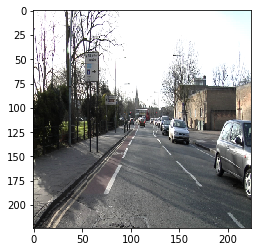

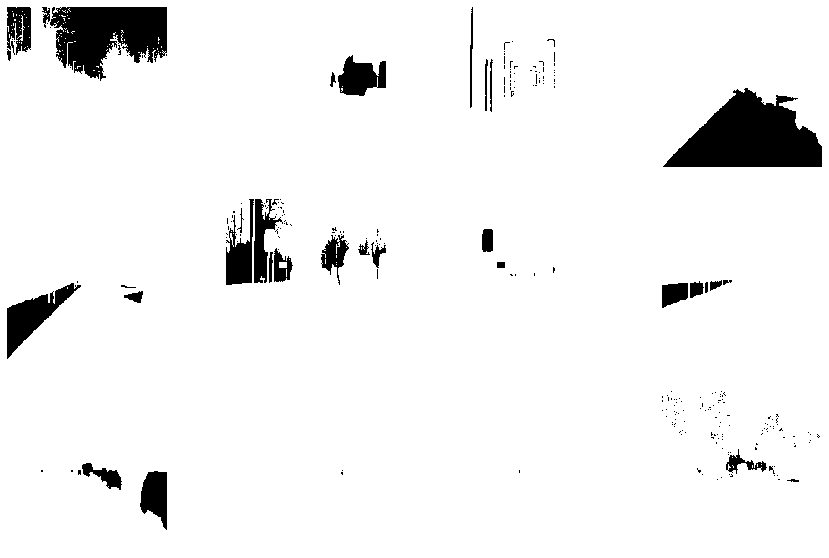

In [0]:
plt.imshow(img_is/255.0)
fig , ax = plt.subplots(3,4, figsize=(15,10))

for i , ax in enumerate(ax.flat):
  ax.imshow((seg[:,:,0]==i)*1.0, cmap='binary')
  ax.axis('off')

In [0]:
X_train = []
seg_images_train = []
for i in range(len(ldseg)):
  seg_images_train.append(img_to_array(load_img(dir_seg + '/' + ldseg[i], color_mode='grayscale', target_size=(224,224)), dtype=int))
  X_train.append(img_to_array(load_img(dir_img + '/' + ldseg[i], target_size=(224,224))))

X_train = np.array(X_train)/255.0  
seg_images_train = np.array(seg_images_train)

In [0]:
X_test = []
seg_images_test = []
for i in range(len(ldseg_test)):
  seg_images_test.append(img_to_array(load_img(dir_seg_test + '/' + ldseg_test[i], color_mode='grayscale', target_size=(224,224)), dtype=int))
  X_test.append(img_to_array(load_img(dir_img_test + '/' + ldseg_test[i], target_size=(224,224))))

X_test = np.array(X_test)/255.0  
seg_images_test = np.array(seg_images_test)

In [0]:
seg_images_test.shape

(101, 224, 224, 1)

In [0]:
seg_images_train.shape

(367, 224, 224, 1)

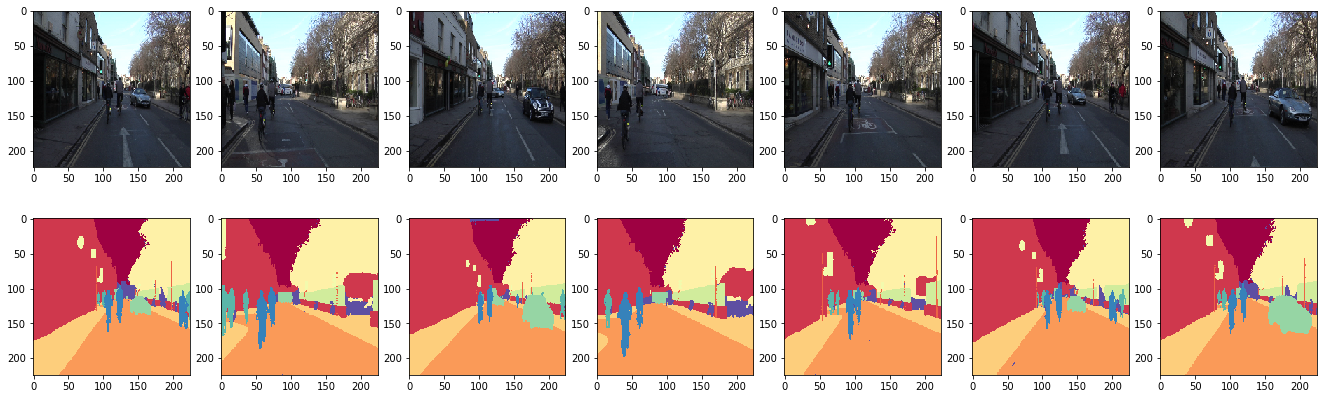

In [0]:
fig , ax = plt.subplots(2,7, figsize=(23,7))

for i in range(7):
  ax[0,i].imshow(X_test[i])
  ax[1,i].imshow(seg_images_test[i,:,:,0], cmap='Spectral')

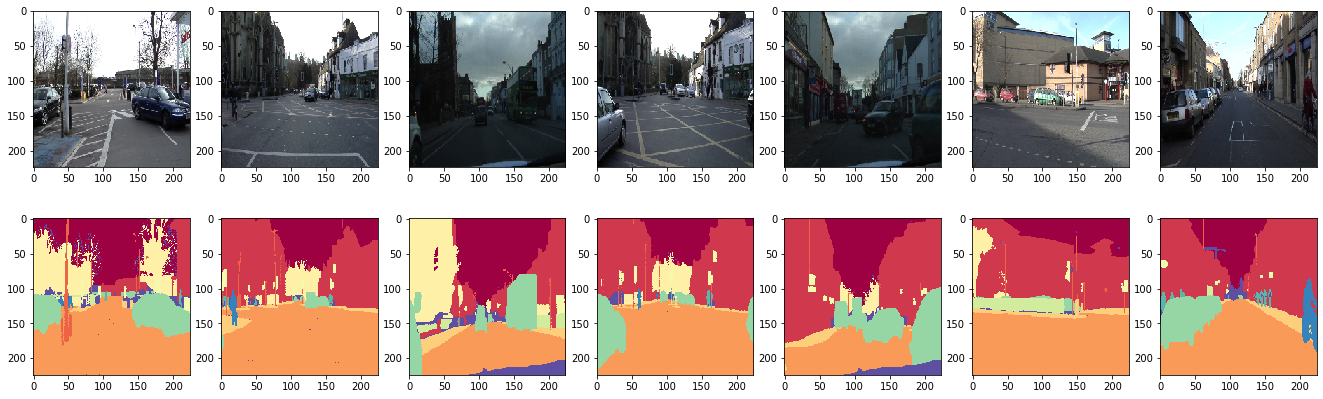

In [0]:
fig , ax = plt.subplots(2,7, figsize=(23,7))

for i in range(7):
  ax[0,i].imshow(X_train[i])
  ax[1,i].imshow(seg_images_train[i,:,:,0], cmap='Spectral')

In [0]:
y_train = []
for i in range(367):
  seg_labels= np.zeros((224,224,12))
  for j in range(12):
    seg_labels[:, :, j] = (seg_images_train[i,:,:,0]==j)*1.0

  y_train.append(seg_labels)

y_train = np.array(y_train)  

In [0]:
y_test = []
for i in range(101):
  seg_labels= np.zeros((224,224,12))
  for j in range(12):
    seg_labels[:, :, j] = (seg_images_test[i,:,:,0]==j)*1.0

  y_test.append(seg_labels)

y_test = np.array(y_test)  

In [0]:
y_train.shape

(367, 224, 224, 12)

In [0]:
y_test.shape

(101, 224, 224, 12)

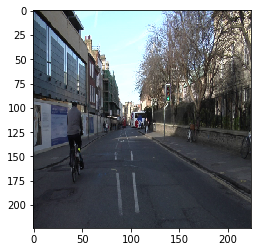

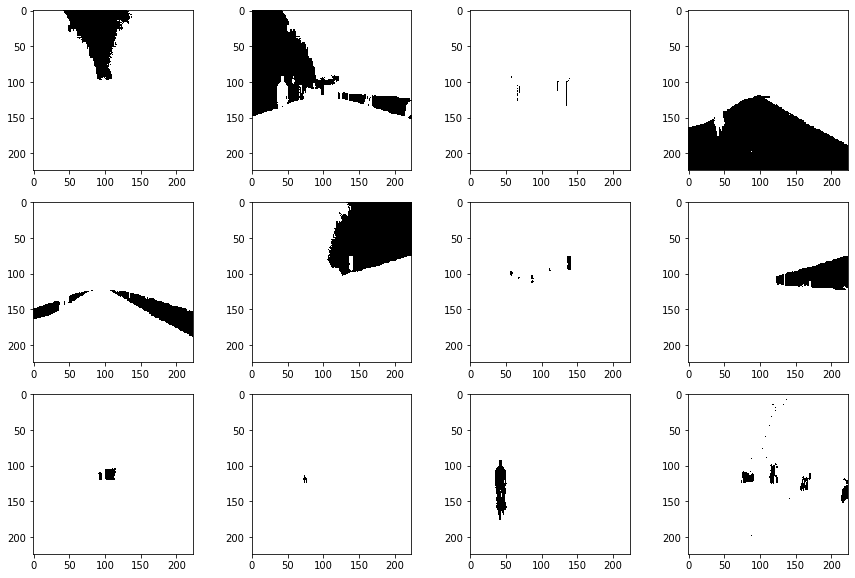

In [0]:
plt.imshow(X_test[10])
fig , ax = plt.subplots(3,4, figsize=(15,10))

for i , ax in enumerate(ax.flat):
  ax.imshow(y_test[10,:,:,i], cmap='binary')
  #ax.axis('off')

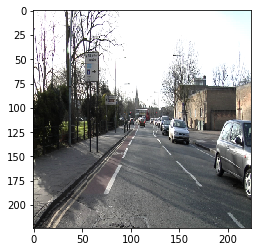

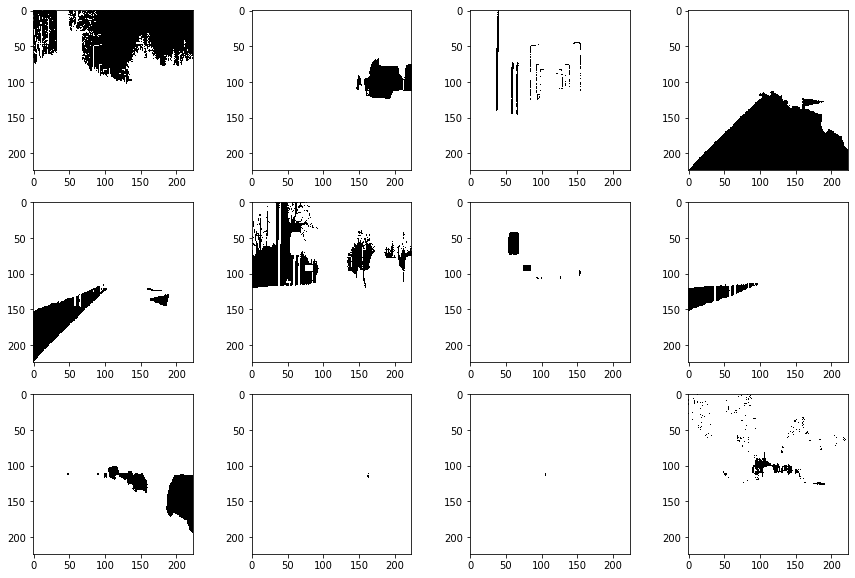

In [0]:
plt.imshow(X_train[10])
fig , ax = plt.subplots(3,4, figsize=(15,10))

for i , ax in enumerate(ax.flat):
  ax.imshow(y_train[10,:,:,i], cmap='binary')
  #ax.axis('off')

In [0]:
np.save('X_train', X_train)
np.save('X_test', X_test)
np.save('y_train', y_train)
np.save('y_test', y_test)

#### Model Unet by hand

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/DataSets/Image/dataset1

/content/drive/My Drive/DataSets/Image/dataset1


In [0]:
ls

annotations_prepped_test/   images_prepped_test/   X_train.npy
annotations_prepped_train/  images_prepped_train/  y_test.npy
cnn_autoencoder.h5          X_test.npy             y_train.npy


In [0]:
%tensorflow_version 1.x

In [0]:
from tensorflow import keras

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()

In [0]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [0]:
#!pip install keras-segmentation

In [0]:
from tensorflow import keras

In [0]:
#keras.backend.clear_session()

In [0]:
def conv_block(filters, x):
  x = keras.layers.Conv2D(filters, kernel_size=3, padding='same', activation='elu', kernel_initializer='he_normal')(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Conv2D(filters, kernel_size=3, padding='same', activation='elu', kernel_initializer='he_normal')(x)

  return x

def upsampling(filters,x):
  x = keras.layers.Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', activation='elu', kernel_initializer='he_normal')(x)
  return x


In [0]:
def unet_mini():
  img_input = keras.layers.Input(shape=(224,224,3))

  c1 = conv_block(32, img_input)
  p1 = keras.layers.MaxPool2D(pool_size=2)(c1)

  c2 = conv_block(64, p1)
  p2 = keras.layers.MaxPool2D(pool_size=2)(c2)

  c3 = conv_block(128, p2)
  p3 = keras.layers.MaxPool2D(pool_size=2)(c3)

  c4 = conv_block(256, p3)

  up1 = upsampling(128, c4)
  up1 = keras.layers.concatenate([up1,c3])
  c5 = conv_block(128, up1)

  up2 = upsampling(64, c5)
  up2 = keras.layers.concatenate([up2,c2])
  c6 = conv_block(64, up2)

  up3 = upsampling(32, c6)
  up3 = keras.layers.concatenate([up3,c1])
  c7 = conv_block(32, up3)


  output = keras.layers.Conv2D(12, kernel_size=1,  padding='same', activation='softmax')(c7)
  
  return keras.Model(img_input, output)

In [0]:
keras.backend.clear_session()

In [0]:
unet = unet_mini()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 224, 224, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [0]:
from tensorflow.keras import backend as K

def dice(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [0]:
#early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [0]:
unet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
%time unet.fit(X_train,y_train, epochs=50, batch_size=32 ,validation_data=(X_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 367 samples, validate on 101 samples
Epoch 1/50
367/367 [==============================] - 25s 67ms/sample - loss: 2.1248 - acc: 0.3173 - val_loss: 1.7764 - val_acc: 0.3823
Epoch 2/50
367/367 [==============================] - 8s 22ms/sample - loss: 1.6284 - acc: 0.4622 - val_loss: 2.0320 - val_acc: 0.3917
Epoch 3/50
367/367 [==============================] - 8s 22ms/sample - loss: 1.3290 - acc: 0.5905 - val_loss: 3.0756 - val_acc: 0.3858
Epoch 4/50
367/367 [==============================] - 8s 22ms/sample - loss: 1.2567 - acc: 0.6068 - val_loss: 1.8358 - val_acc: 0.4541
Epoch 5/50
367/367 [==============================] - 8s 22ms/sample - loss: 1.1186 - acc: 0.6485 - val_loss: 2.3190 - val_acc: 0.4544
Epoch 6/50
367/367 [==============================] - 8s 22ms/sample - loss: 1.0084 - acc: 0.6631 - val_loss: 2.7512 - val_acc: 0.4401
Epoch 7/50
367/367 [=============================

In [0]:
predicted = unet.predict(X_test)

In [0]:
predicted = predicted.argmax(axis=-1)

In [0]:
predicted.shape

(101, 224, 224)

In [0]:
predicted.dtype

dtype('int64')

In [0]:
y_test.max(axis=-1)[0].shape

(224, 224)

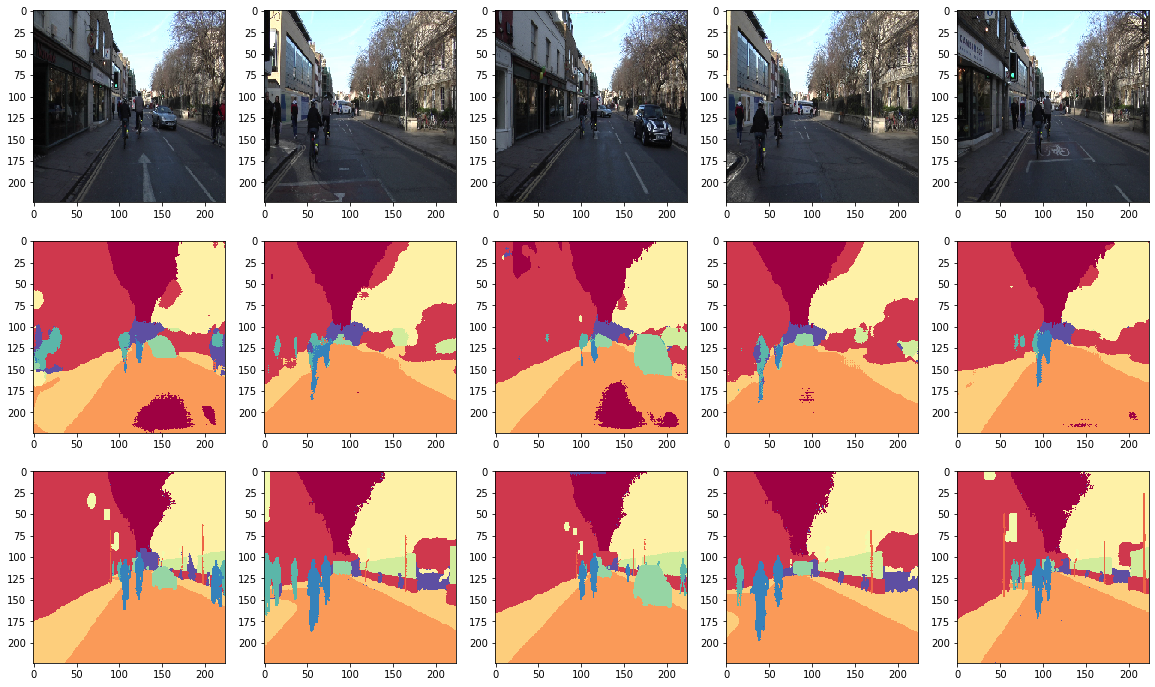

In [0]:
fig , ax = plt.subplots(3,5, figsize=(20,12))

for i in range(5):
  ax[0,i].imshow(X_test[i])
  ax[1,i].imshow(predicted[i,:,:], cmap='Spectral')
  ax[2,i].imshow(y_test.argmax(axis=-1)[i,:,:], cmap='Spectral')

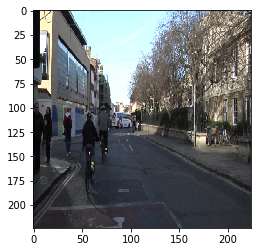

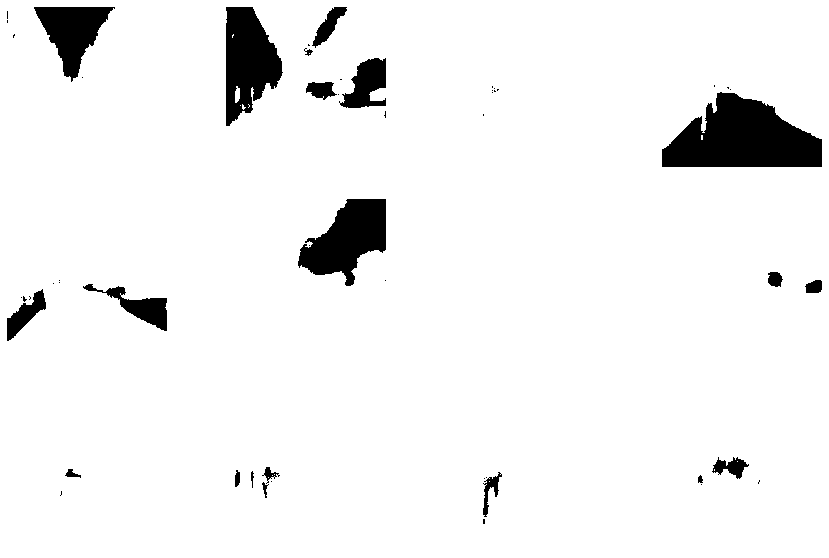

In [0]:
plt.imshow(X_test[1])
fig , ax = plt.subplots(3,4, figsize=(15,10))

for i , ax in enumerate(ax.flat):
  ax.imshow((predicted[1,:,:]==i)*1.0, cmap='binary')
  ax.axis('off')

####  Using libraries and pretrained nets

In [0]:
!pip install segmentation_models 

In [0]:
#keras.backend.clear_session()

In [0]:
from tensorflow import keras

In [0]:
import segmentation_models as sm

In [0]:
model_unet = sm.Unet(backbone_name='vgg16',input_shape=(224,224,3), classes=12, activation='softmax',encoder_weights='imagenet', encoder_freeze=True)

In [0]:
model_unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [0]:
model_unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [0]:
model_unet.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Train on 367 samples, validate on 101 samples
Epoch 1/30
367/367 [==============================] - 10s 28ms/step - loss: 2.0301 - acc: 0.3994 - val_loss: 1.8845 - val_acc: 0.3417
Epoch 2/30
367/367 [==============================] - 7s 20ms/step - loss: 1.1484 - acc: 0.6935 - val_loss: 1.2541 - val_acc: 0.6893
Epoch 3/30
367/367 [==============================] - 7s 20ms/step - loss: 0.8635 - acc: 0.7506 - val_loss: 0.8935 - val_acc: 0.7704
Epoch 4/30
367/367 [==============================] - 7s 20ms/step - loss: 0.7272 - acc: 0.7724 - val_loss: 0.8150 - val_acc: 0.7745
Epoch 5/30
367/367 [==============================] - 7s 20ms/step - loss: 0.6431 - acc: 0.7888 - val_loss: 0.6947 - val_acc: 0.7741
Epoch 6/30
367/367 [==============================] - 7s 20ms/step - loss: 0.5690 - acc: 0.8387 - val_loss: 0.6339 - val_acc: 0.8272
Epoch 7/30
367/367 [==============================] - 7s 20ms/step - loss: 0.5172 - acc: 0.8548 - val_loss: 0.6553 - val_acc: 0.8152
Epoch 8/30
367/367 [==

In [0]:
predicted = model_unet.predict(X_test)

In [0]:
predicted = predicted.argmax(axis=-1)

In [0]:
predicted.shape

(101, 224, 224)

In [0]:
predicted.dtype

dtype('int64')

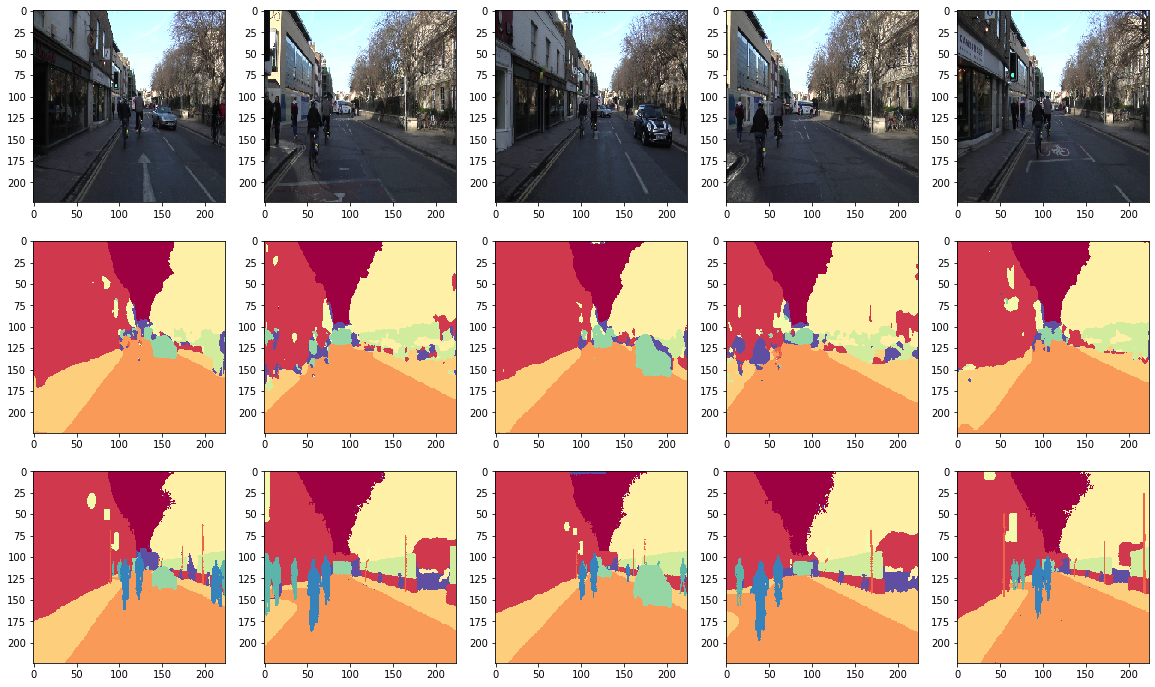

In [0]:
fig , ax = plt.subplots(3,5, figsize=(20,12))

for i in range(5):
  ax[0,i].imshow(X_test[i])
  ax[1,i].imshow(predicted[i,:,:], cmap='Spectral')
  ax[2,i].imshow(y_test.argmax(axis=-1)[i,:,:], cmap='Spectral')

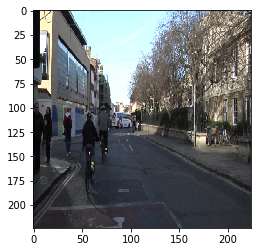

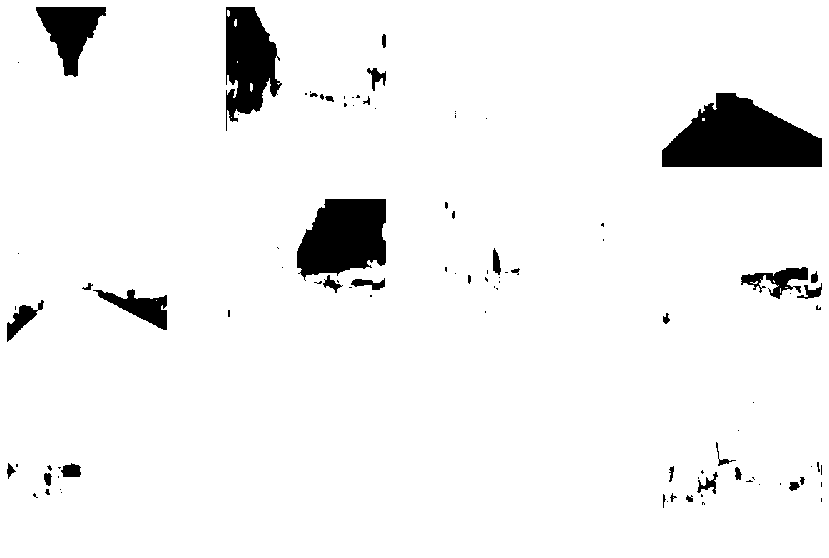

In [0]:
plt.imshow(X_test[1])
fig , ax = plt.subplots(3,4, figsize=(15,10))

for i , ax in enumerate(ax.flat):
  ax.imshow((predicted[1,:,:]==i)*1.0, cmap='binary')
  ax.axis('off')

In [0]:
#!pip install segmentation_models

In [0]:
#from segmentation_models import Unet

In [0]:
#Unet(input_shape=(224,224,3))